In [31]:
import os
import kagglehub

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [32]:
# Load the heart_rate from dataset
df = pd.read_csv('heartrate_seconds_merged.csv', parse_dates=['Time'])

In [33]:
df['Id'].nunique()

14

In [34]:
# Count number of entries for each Id
id_counts = df['Id'].value_counts()
print(id_counts)

Id
4020332650    283794
6962181067    125875
2347167796    120804
5553957443     97797
5577150313     87649
8877689391     85115
8792009665     70087
4558609924     69339
7007744171     64786
2022484408     56483
6117666160     53666
6775888955     35100
6391747486      3747
2026352035       439
Name: count, dtype: int64


In [35]:
all_ids = df['Id'].unique()
print(all_ids)

[2022484408 2026352035 2347167796 4020332650 4558609924 5553957443
 5577150313 6117666160 6391747486 6775888955 6962181067 7007744171
 8792009665 8877689391]


##  missing values with the average value for that minute across all days.

In [36]:
def fill_zeros_and_nans_with_minute_avg(df, value_col='Value'):
    """
    Fills both 0 and NaN values in the specified column with the average value for that minute of the day
    across all days (excluding other 0's), then rounds and casts to int.
    
    Assumes:
    - df has a datetime index named 'Time' or similar.
    - The column contains numeric values (e.g., heart rate).
    
    Parameters:
    - df: DataFrame with datetime index and the value column.
    - value_col: Name of the column to fill (default: 'Value').
    
    Returns:
    - DataFrame with 0's and NaN's replaced, rounded, and cast to int64.
    """
    df = df.copy()
    
    # Ensure index is datetime
    df.index = pd.to_datetime(df.index)
    
    # Extract minute of day
    df['minute_of_day'] = df.index.hour * 60 + df.index.minute
    
    # Compute average for each minute, excluding 0's (but including non-NaN, non-zero values)
    non_zero_data = df[df[value_col].notna() & (df[value_col] != 0)]
    minute_avg = non_zero_data.groupby('minute_of_day')[value_col].mean()
    
    # Replace 0's and NaN's with the corresponding minute average
    mask = (df[value_col] == 0) | df[value_col].isna()
    if mask.any():
        # Map, fill any missing avgs with 0, round, and cast to int64 before assignment
        replacements = df.loc[mask, 'minute_of_day'].map(minute_avg).fillna(0).round().astype('int64')
        df.loc[mask, value_col] = replacements
    
    # Ensure entire column is int64 (in case originals weren't)
    df[value_col] = df[value_col].astype('int64')
    
    # Clean up temp column
    df.drop('minute_of_day', axis=1, inplace=True)
    
    return df

In [38]:
def hr_plot(df,id):
        df.plot(style='.',
                figsize=(15, 5),
                color=color_pal[0],
                title=f'HR of User ID: {id}, over time')
        plt.show()

In [41]:
def create_features(df):
    """
    Create time series features and lag features based on time series index.
    """
    df = df.copy()

    # Basic time-based features
    df['minute'] = df.index.minute
    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month

    # Lag features
    df['lag_1minute'] = df['Value'].shift(1)  # 1 minute lag
    df['lag_1h'] = df['Value'].shift(60)   # 1 hour lag
    df['lag_1d'] = df['Value'].shift(1440)  # 1 day lag
    df['lag_1w'] = df['Value'].shift(10080) # 1 week lag

    # Rolling statistics features
    df['rolling_mean_30minutes'] = df['Value'].rolling(window=30).mean()  # Last 30 minutes rolling mean
    df['rolling_mean_3hours'] = df['Value'].rolling(window=180).mean()  # Last 3 hours rolling mean
    df['rolling_mean_3days'] = df['Value'].rolling(window=4320).mean()  # Last 3 days rolling mean
    df['rolling_mean_same_hour_last_day'] = df['Value'].shift(1440).rolling(window=30).mean()  # Same hour previous day rolling mean
    df['rolling_mean_same_hour_last_week'] = df['Value'].shift(10080).rolling(window=7).mean()  # Same hour previous week rolling mean

    return df

In [42]:
def app_model_xgb(df):
    df = df.to_frame()
    
    # Calculate the split date: max date minus 2 days (test will be the last two days inclusive)
    split_date = df.index.max() - pd.Timedelta(days=2)

    # Split the data
    train = df.loc[df.index < split_date]
    test = df.loc[df.index >= split_date]

    train = create_features(train)
    test = create_features(test)

    TARGET = 'Value'

    FEATURES_XGB = [
        'hour', 'dayofweek', 'month', 'minute', 'day','lag_1minute', 'lag_1h', 'lag_1d', 'lag_1w',
        'rolling_mean_30minutes', 'rolling_mean_3hours', 'rolling_mean_3days', 'rolling_mean_same_hour_last_day', 'rolling_mean_same_hour_last_week'
    ]
    # XGBoost Data
    X_train_xgb = train[FEATURES_XGB]
    y_train_xgb = train[TARGET]

    X_test_xgb = test[FEATURES_XGB]
    y_test_xgb = test[TARGET]

    # Create DMatrix for XGBoost
    dtrain = xgb.DMatrix(X_train_xgb, label=y_train_xgb)
    dtest = xgb.DMatrix(X_test_xgb, label=y_test_xgb)

    # Set parameters for XGBoost
    params = {
        'objective': 'reg:squarederror',  # Objective function for regression
        'eval_metric': 'rmse',  # Evaluation metric
        'max_depth': 3,  # Depth of the trees
        'learning_rate': 0.01,  # Learning rate
        'colsample_bytree': 0.8,  # Subsample of features
        'subsample': 0.8  # Subsample ratio
    }

    # Watchlist for monitoring performance on train and test sets
    watchlist = [(dtrain, 'train'), (dtest, 'eval')]

    # Number of boosting rounds and early stopping
    num_round = 1000  # Number of boosting rounds
    early_stopping_rounds = 50  # Early stopping

    # Train the model
    reg = xgb.train(params, dtrain, num_round, watchlist, early_stopping_rounds=early_stopping_rounds,verbose_eval=100)

    # # Predict on the test set
    y_pred_xgb = reg.predict(dtest)

    # @title **Evaluating XGBoost**
    rmse_xgb = np.sqrt(mean_squared_error(y_test_xgb, y_pred_xgb))
    mae_xgb = mean_absolute_error(y_test_xgb, y_pred_xgb)
    return rmse_xgb, mae_xgb

User ID: 2022484408, Number of NaNs before filling: 0
User ID: 2022484408, Number of NaNs after filling: 0


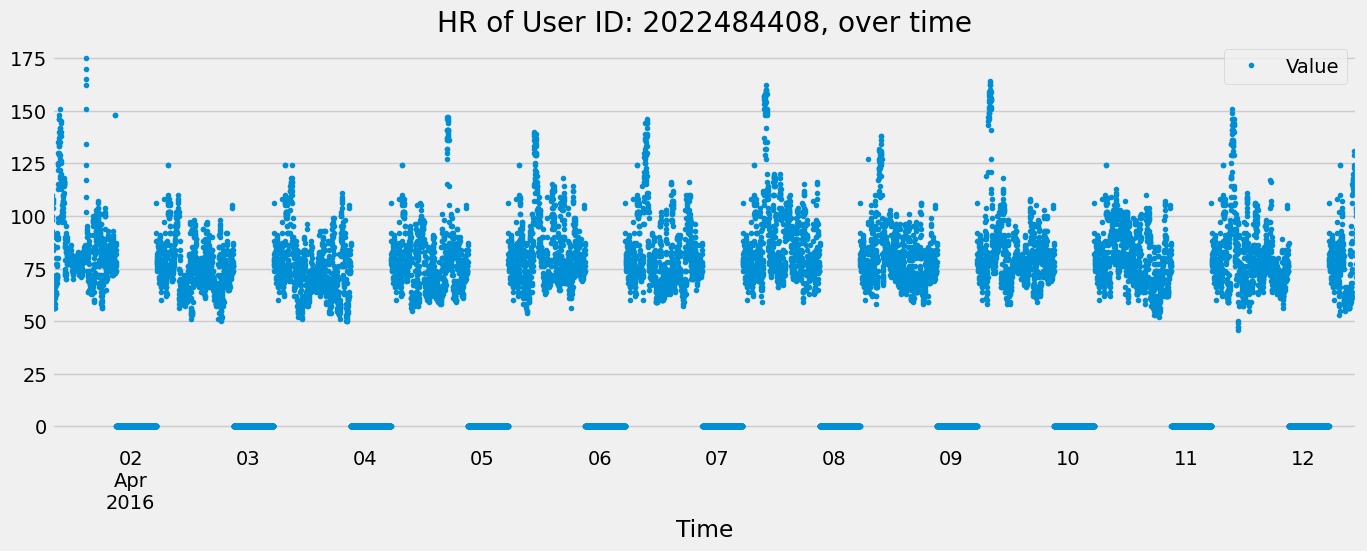

[0]	train-rmse:39.88846	eval-rmse:39.18858
[100]	train-rmse:15.83531	eval-rmse:15.58380


c:\Users\ronys\Documents\RUC\advanced-project\A_P_Python\advanced-project\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[200]	train-rmse:7.67955	eval-rmse:7.88975
[300]	train-rmse:5.26085	eval-rmse:5.83877
[400]	train-rmse:4.70503	eval-rmse:5.47255
[500]	train-rmse:4.54136	eval-rmse:5.37592
[600]	train-rmse:4.46055	eval-rmse:5.33316
[700]	train-rmse:4.41150	eval-rmse:5.31454
[800]	train-rmse:4.37316	eval-rmse:5.29943
[900]	train-rmse:4.33977	eval-rmse:5.28282
[999]	train-rmse:4.31275	eval-rmse:5.27594
User ID: 2026352035, Number of NaNs before filling: 0
User ID: 2026352035, Number of NaNs after filling: 0


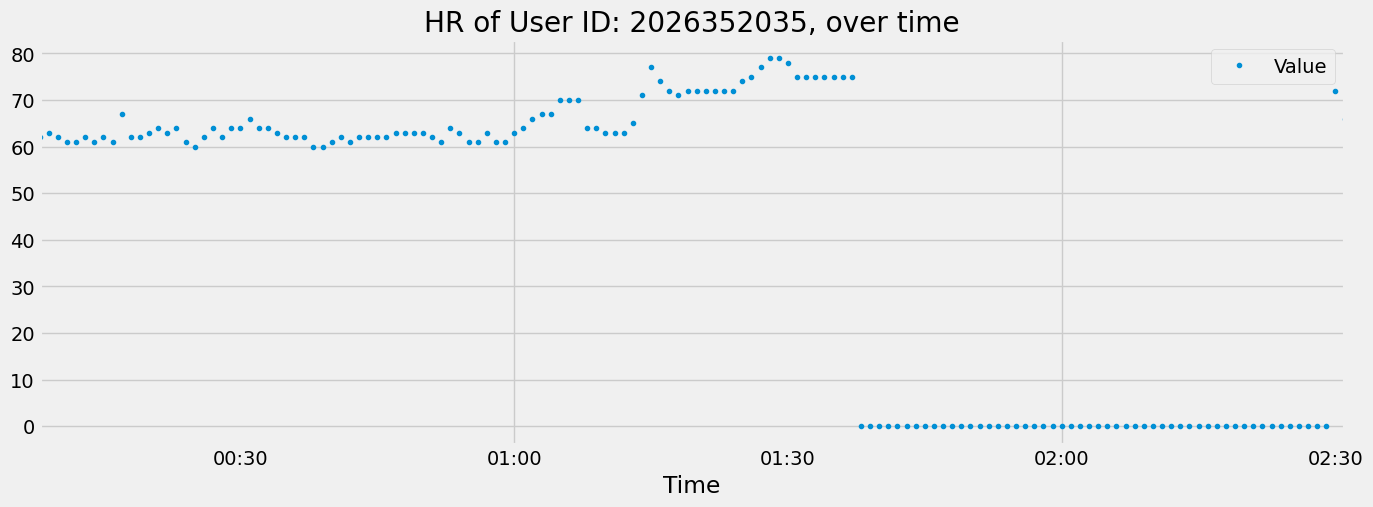

[0]	train-rmse:0.00000	eval-rmse:53.02070
[49]	train-rmse:0.00000	eval-rmse:53.02070


c:\Users\ronys\Documents\RUC\advanced-project\A_P_Python\advanced-project\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


User ID: 2347167796, Number of NaNs before filling: 0
User ID: 2347167796, Number of NaNs after filling: 0


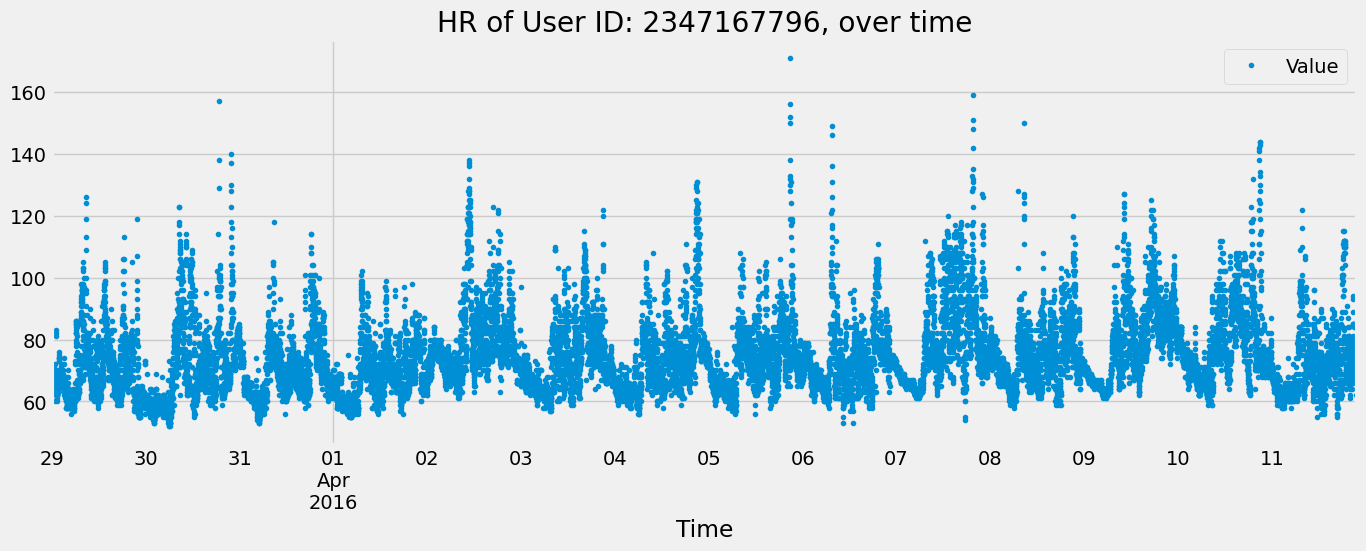

[0]	train-rmse:11.91447	eval-rmse:12.19776
[100]	train-rmse:6.35182	eval-rmse:6.52466


c:\Users\ronys\Documents\RUC\advanced-project\A_P_Python\advanced-project\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[200]	train-rmse:4.81822	eval-rmse:4.94977
[300]	train-rmse:4.43216	eval-rmse:4.56188
[400]	train-rmse:4.33980	eval-rmse:4.49121
[500]	train-rmse:4.29893	eval-rmse:4.46793
[600]	train-rmse:4.27185	eval-rmse:4.46267
[700]	train-rmse:4.25103	eval-rmse:4.46044
[705]	train-rmse:4.24997	eval-rmse:4.46026
User ID: 4020332650, Number of NaNs before filling: 0
User ID: 4020332650, Number of NaNs after filling: 0


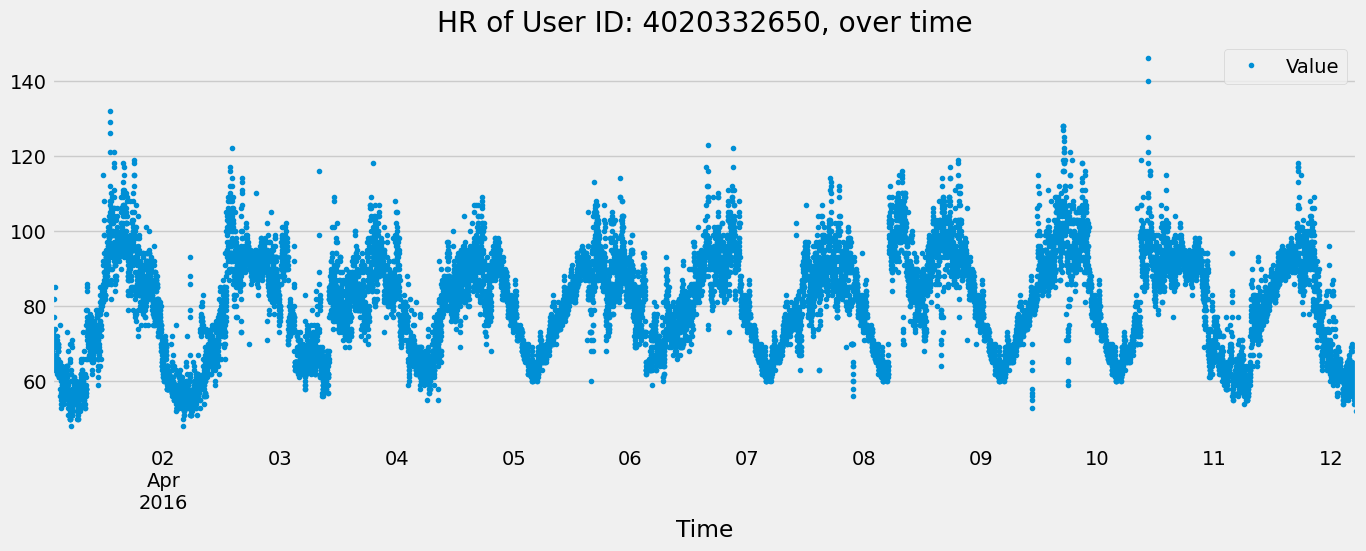

[0]	train-rmse:13.06639	eval-rmse:13.61685
[100]	train-rmse:6.14991	eval-rmse:6.20117


c:\Users\ronys\Documents\RUC\advanced-project\A_P_Python\advanced-project\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[200]	train-rmse:4.19972	eval-rmse:4.06464
[300]	train-rmse:3.77629	eval-rmse:3.60060
[400]	train-rmse:3.68525	eval-rmse:3.51785
[500]	train-rmse:3.65149	eval-rmse:3.49850
[600]	train-rmse:3.63257	eval-rmse:3.48884
[700]	train-rmse:3.61856	eval-rmse:3.48428
[800]	train-rmse:3.60645	eval-rmse:3.48074
[900]	train-rmse:3.59428	eval-rmse:3.47952
[999]	train-rmse:3.58242	eval-rmse:3.47713
User ID: 4558609924, Number of NaNs before filling: 0
User ID: 4558609924, Number of NaNs after filling: 0


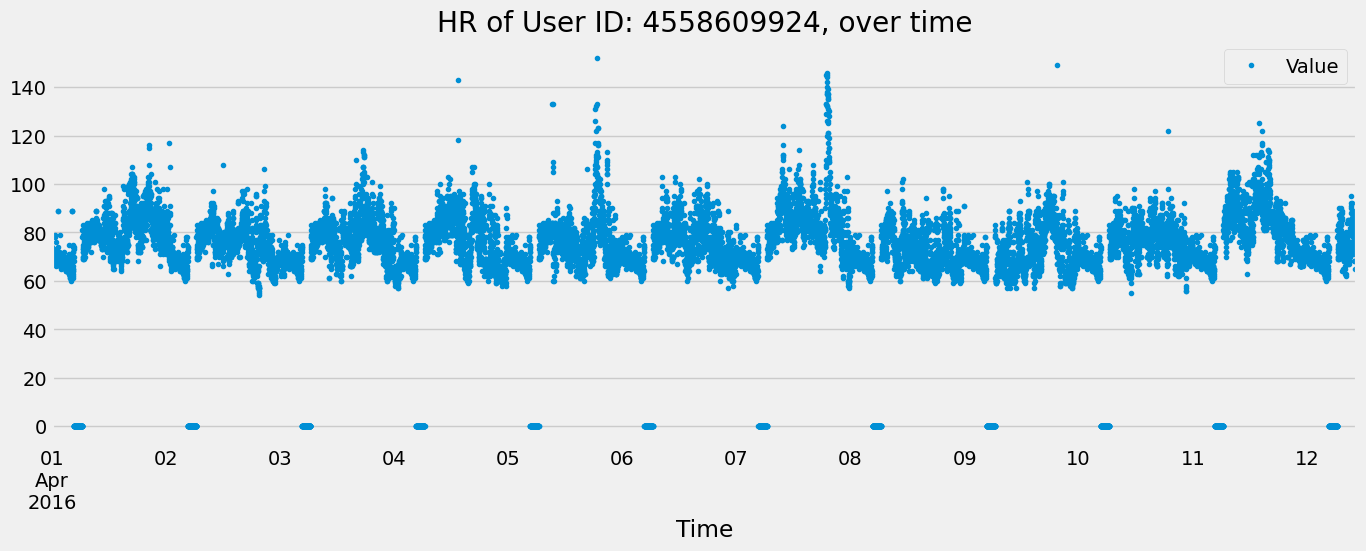

[0]	train-rmse:22.22979	eval-rmse:22.41241


c:\Users\ronys\Documents\RUC\advanced-project\A_P_Python\advanced-project\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[100]	train-rmse:9.56485	eval-rmse:10.02895
[200]	train-rmse:5.55119	eval-rmse:6.09701
[300]	train-rmse:4.46691	eval-rmse:4.93134
[400]	train-rmse:4.21790	eval-rmse:4.61666
[500]	train-rmse:4.13390	eval-rmse:4.52215
[600]	train-rmse:4.09129	eval-rmse:4.49641
[700]	train-rmse:4.06324	eval-rmse:4.48411
[800]	train-rmse:4.04017	eval-rmse:4.47327
[900]	train-rmse:4.01906	eval-rmse:4.46715
[999]	train-rmse:3.99979	eval-rmse:4.46153
User ID: 5553957443, Number of NaNs before filling: 0
User ID: 5553957443, Number of NaNs after filling: 0


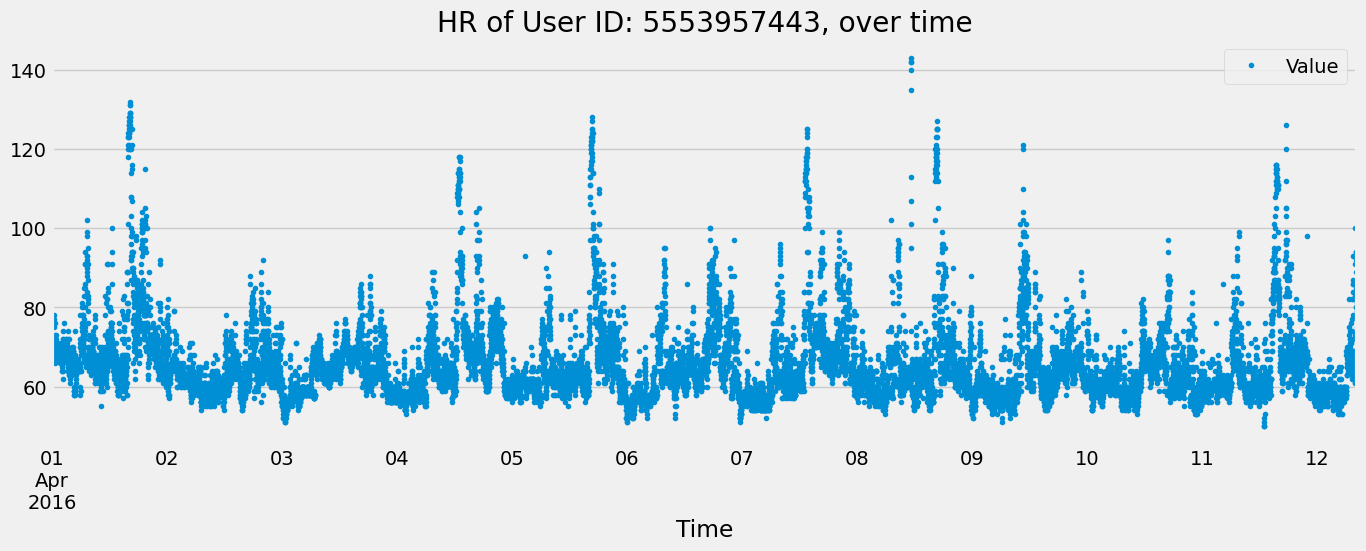

[0]	train-rmse:9.94333	eval-rmse:9.40112
[100]	train-rmse:5.06407	eval-rmse:4.82520


c:\Users\ronys\Documents\RUC\advanced-project\A_P_Python\advanced-project\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[200]	train-rmse:3.64671	eval-rmse:3.57509
[300]	train-rmse:3.27105	eval-rmse:3.29928
[400]	train-rmse:3.17730	eval-rmse:3.24713
[500]	train-rmse:3.13430	eval-rmse:3.23059
[600]	train-rmse:3.11083	eval-rmse:3.22369
[700]	train-rmse:3.09434	eval-rmse:3.21984
[800]	train-rmse:3.08034	eval-rmse:3.21862
[827]	train-rmse:3.07696	eval-rmse:3.21922
User ID: 5577150313, Number of NaNs before filling: 0
User ID: 5577150313, Number of NaNs after filling: 0


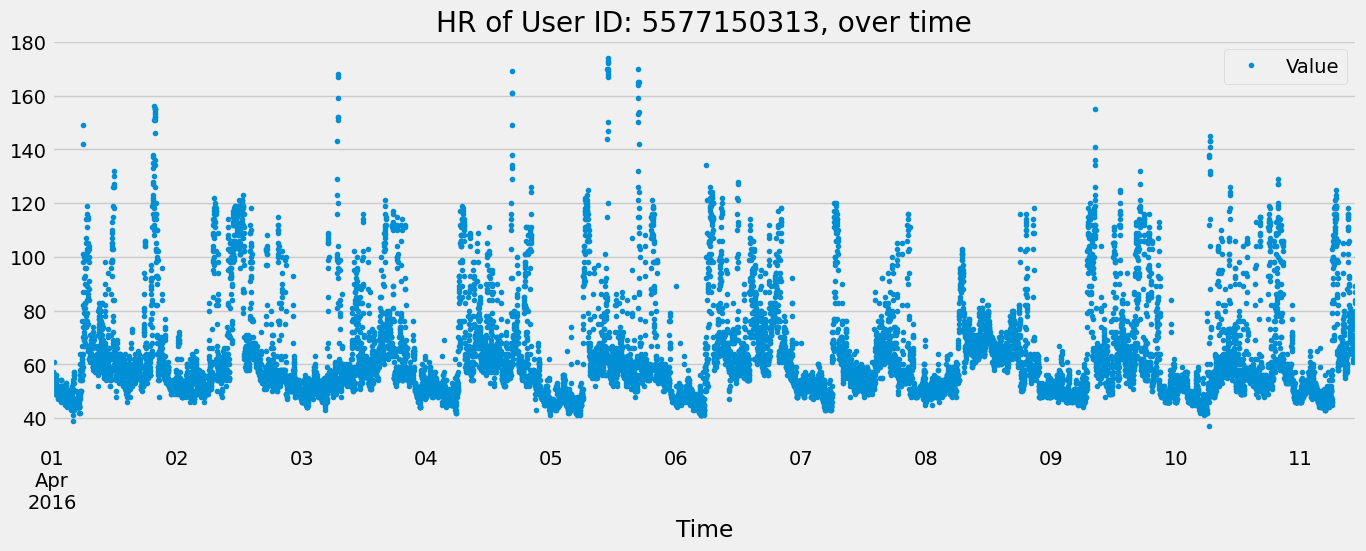

[0]	train-rmse:17.61975	eval-rmse:18.47767
[100]	train-rmse:8.70691	eval-rmse:9.47526


c:\Users\ronys\Documents\RUC\advanced-project\A_P_Python\advanced-project\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[200]	train-rmse:5.98657	eval-rmse:6.89416
[300]	train-rmse:5.16362	eval-rmse:6.12037
[400]	train-rmse:4.94623	eval-rmse:5.92288
[500]	train-rmse:4.84823	eval-rmse:5.85715
[600]	train-rmse:4.79272	eval-rmse:5.82316
[700]	train-rmse:4.75250	eval-rmse:5.81014
[800]	train-rmse:4.71360	eval-rmse:5.80046
[900]	train-rmse:4.68317	eval-rmse:5.79396
[999]	train-rmse:4.65429	eval-rmse:5.78742
User ID: 6117666160, Number of NaNs before filling: 0
User ID: 6117666160, Number of NaNs after filling: 0


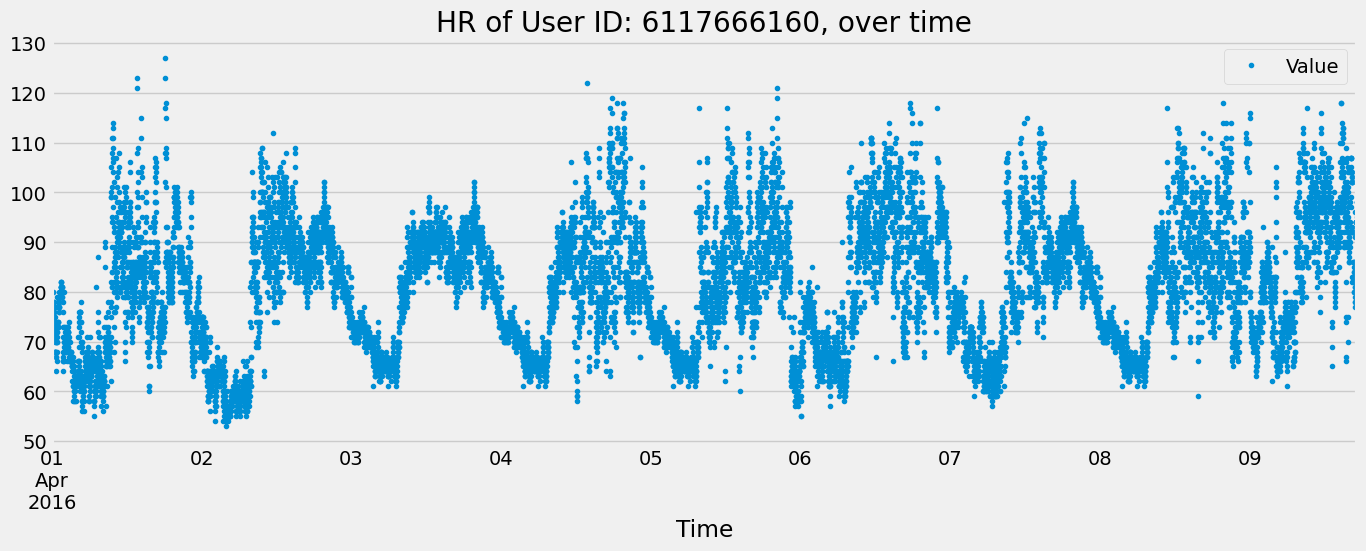

[0]	train-rmse:12.35116	eval-rmse:12.37666
[100]	train-rmse:6.05335	eval-rmse:6.24971


c:\Users\ronys\Documents\RUC\advanced-project\A_P_Python\advanced-project\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[200]	train-rmse:4.31116	eval-rmse:4.55064
[300]	train-rmse:3.90271	eval-rmse:4.14777
[400]	train-rmse:3.80770	eval-rmse:4.06808
[500]	train-rmse:3.76617	eval-rmse:4.04848
[600]	train-rmse:3.74204	eval-rmse:4.04177
[700]	train-rmse:3.72244	eval-rmse:4.03656
[800]	train-rmse:3.70362	eval-rmse:4.03345
[869]	train-rmse:3.69142	eval-rmse:4.03344
User ID: 6391747486, Number of NaNs before filling: 0
User ID: 6391747486, Number of NaNs after filling: 0


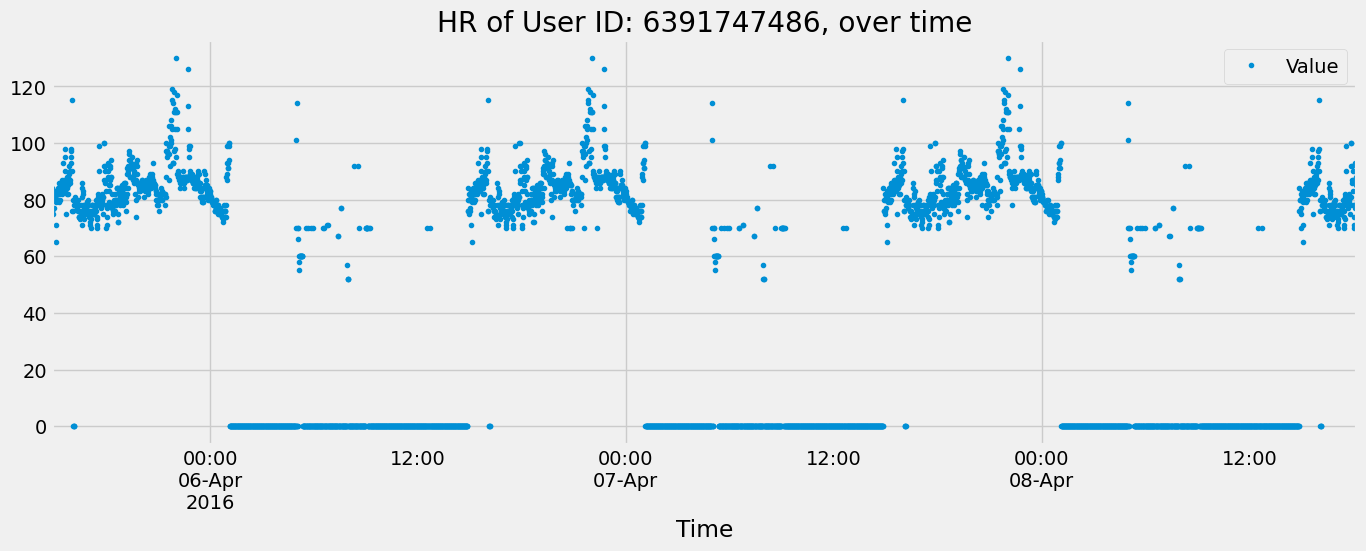

[0]	train-rmse:41.38226	eval-rmse:41.78059
[100]	train-rmse:18.38901	eval-rmse:21.52596
[200]	train-rmse:11.85691	eval-rmse:15.61138


c:\Users\ronys\Documents\RUC\advanced-project\A_P_Python\advanced-project\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[300]	train-rmse:10.39403	eval-rmse:13.65998
[400]	train-rmse:9.95509	eval-rmse:12.98336
[500]	train-rmse:9.71170	eval-rmse:12.48497
[600]	train-rmse:9.54214	eval-rmse:12.06477
[700]	train-rmse:9.35241	eval-rmse:11.64693
[800]	train-rmse:9.19005	eval-rmse:11.42934
[900]	train-rmse:9.00891	eval-rmse:11.24490
[999]	train-rmse:8.84804	eval-rmse:11.10375
User ID: 6775888955, Number of NaNs before filling: 0
User ID: 6775888955, Number of NaNs after filling: 0


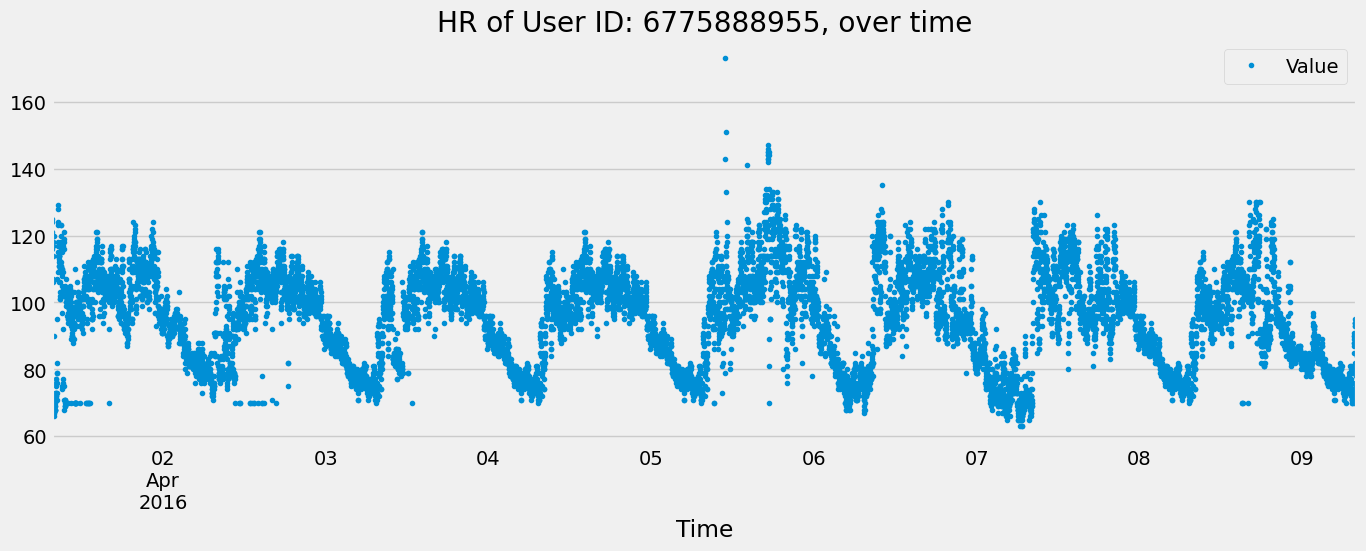

[0]	train-rmse:13.72453	eval-rmse:13.19883
[100]	train-rmse:6.72602	eval-rmse:6.30810


c:\Users\ronys\Documents\RUC\advanced-project\A_P_Python\advanced-project\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[200]	train-rmse:4.69513	eval-rmse:4.45784
[300]	train-rmse:4.16913	eval-rmse:4.02500
[400]	train-rmse:4.01297	eval-rmse:3.93752
[500]	train-rmse:3.93155	eval-rmse:3.91536
[600]	train-rmse:3.87888	eval-rmse:3.90738
[700]	train-rmse:3.84037	eval-rmse:3.90468
[800]	train-rmse:3.80809	eval-rmse:3.90253
[900]	train-rmse:3.77735	eval-rmse:3.90161
[999]	train-rmse:3.74802	eval-rmse:3.90243
User ID: 6962181067, Number of NaNs before filling: 0
User ID: 6962181067, Number of NaNs after filling: 0


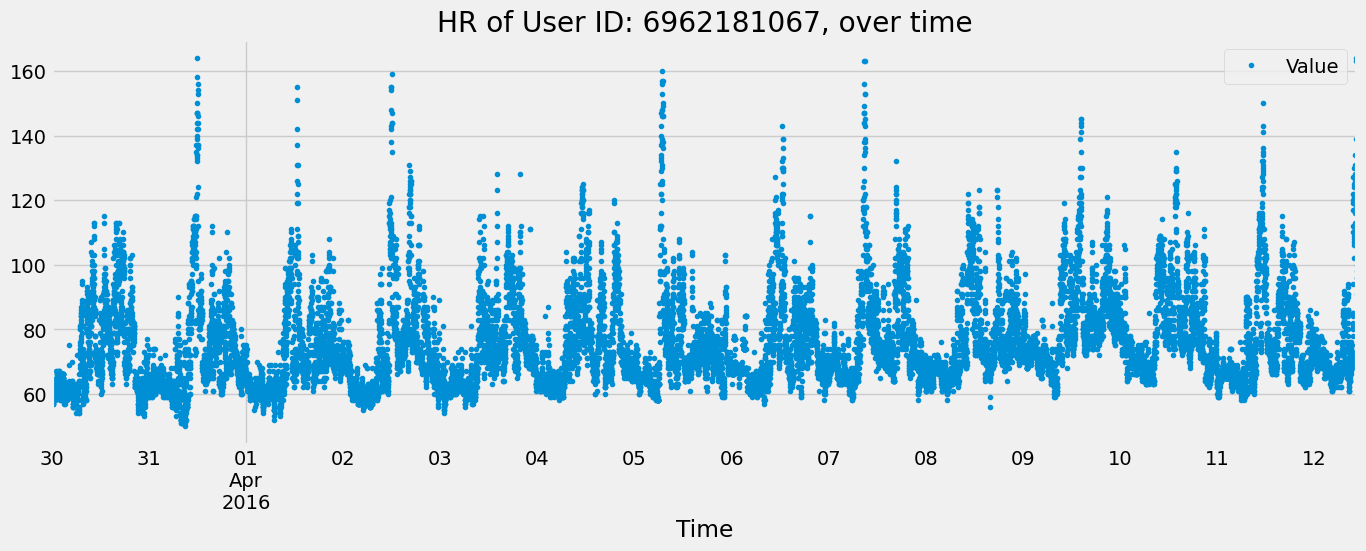

[0]	train-rmse:13.86333	eval-rmse:14.43953
[100]	train-rmse:6.78904	eval-rmse:7.18456


c:\Users\ronys\Documents\RUC\advanced-project\A_P_Python\advanced-project\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[200]	train-rmse:4.70162	eval-rmse:4.96432
[300]	train-rmse:4.14377	eval-rmse:4.32653
[400]	train-rmse:4.01444	eval-rmse:4.18448
[500]	train-rmse:3.96328	eval-rmse:4.13567
[600]	train-rmse:3.93632	eval-rmse:4.11960
[700]	train-rmse:3.91486	eval-rmse:4.10554
[800]	train-rmse:3.89829	eval-rmse:4.09776
[900]	train-rmse:3.88462	eval-rmse:4.09381
[937]	train-rmse:3.87915	eval-rmse:4.09436
User ID: 7007744171, Number of NaNs before filling: 0
User ID: 7007744171, Number of NaNs after filling: 0


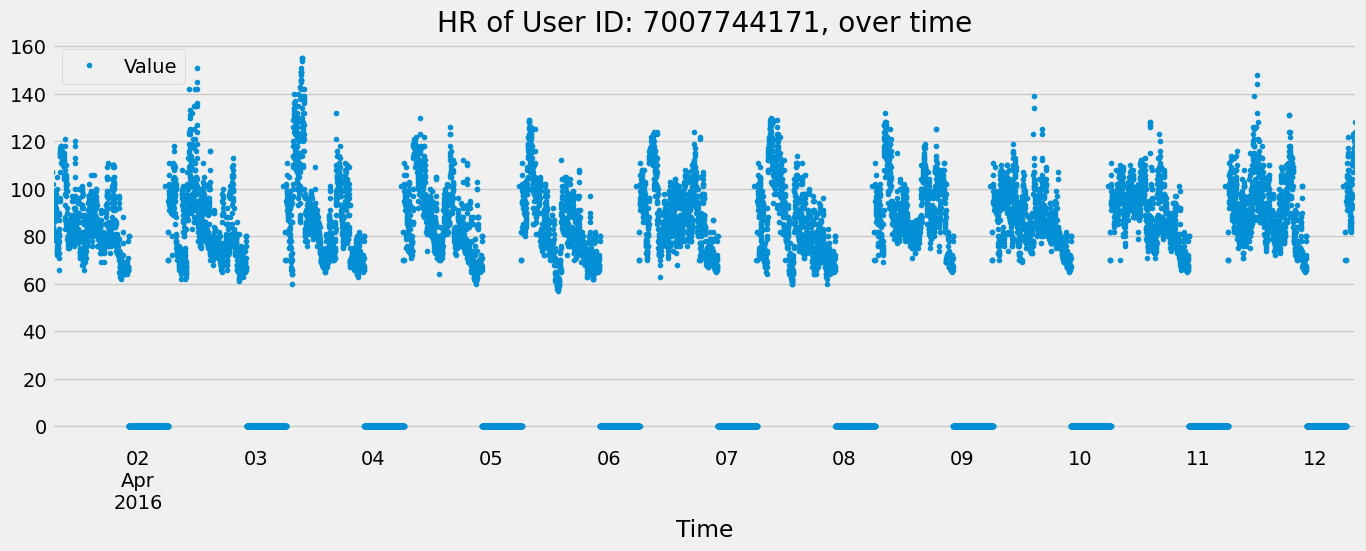

[0]	train-rmse:42.00995	eval-rmse:43.52749
[100]	train-rmse:16.52607	eval-rmse:17.77252


c:\Users\ronys\Documents\RUC\advanced-project\A_P_Python\advanced-project\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[200]	train-rmse:7.74575	eval-rmse:9.13607
[300]	train-rmse:5.09780	eval-rmse:6.70130
[400]	train-rmse:4.47626	eval-rmse:6.08940
[500]	train-rmse:4.31875	eval-rmse:5.92697
[600]	train-rmse:4.25624	eval-rmse:5.87115
[700]	train-rmse:4.22095	eval-rmse:5.85108
[800]	train-rmse:4.19396	eval-rmse:5.83756
[871]	train-rmse:4.17855	eval-rmse:5.84241
User ID: 8792009665, Number of NaNs before filling: 0
User ID: 8792009665, Number of NaNs after filling: 0


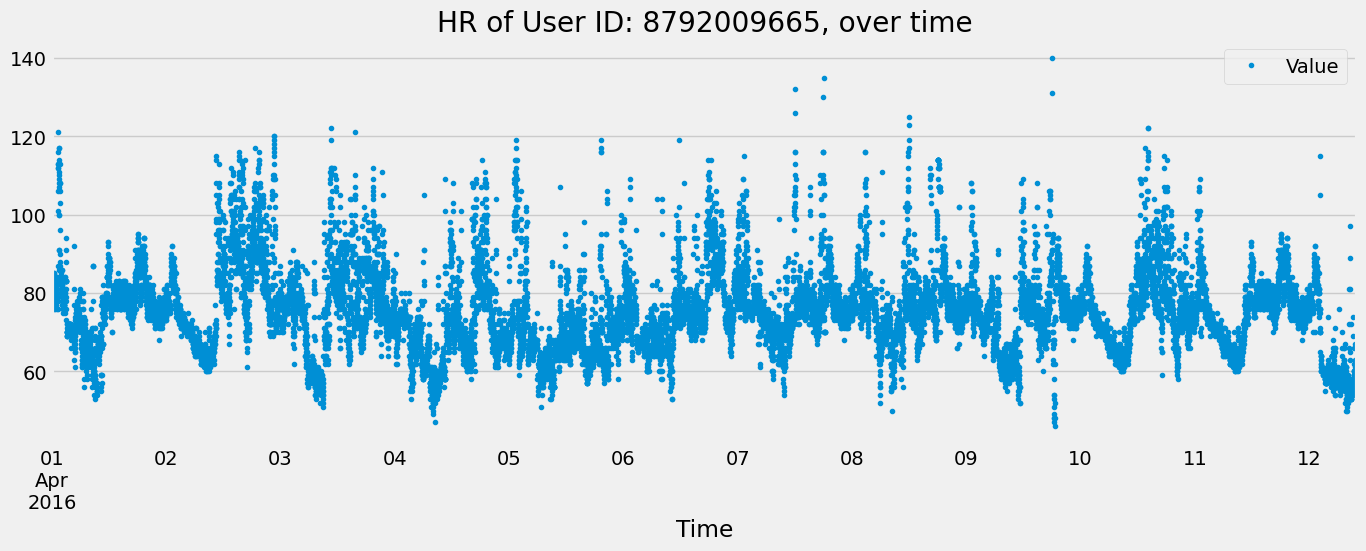

[0]	train-rmse:10.55839	eval-rmse:10.58737
[100]	train-rmse:5.64904	eval-rmse:5.39115


c:\Users\ronys\Documents\RUC\advanced-project\A_P_Python\advanced-project\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[200]	train-rmse:4.31319	eval-rmse:3.90194
[300]	train-rmse:3.97057	eval-rmse:3.57130
[400]	train-rmse:3.88460	eval-rmse:3.51565
[500]	train-rmse:3.84588	eval-rmse:3.50702
[600]	train-rmse:3.81959	eval-rmse:3.50567
[601]	train-rmse:3.81935	eval-rmse:3.50573
User ID: 8877689391, Number of NaNs before filling: 0
User ID: 8877689391, Number of NaNs after filling: 0


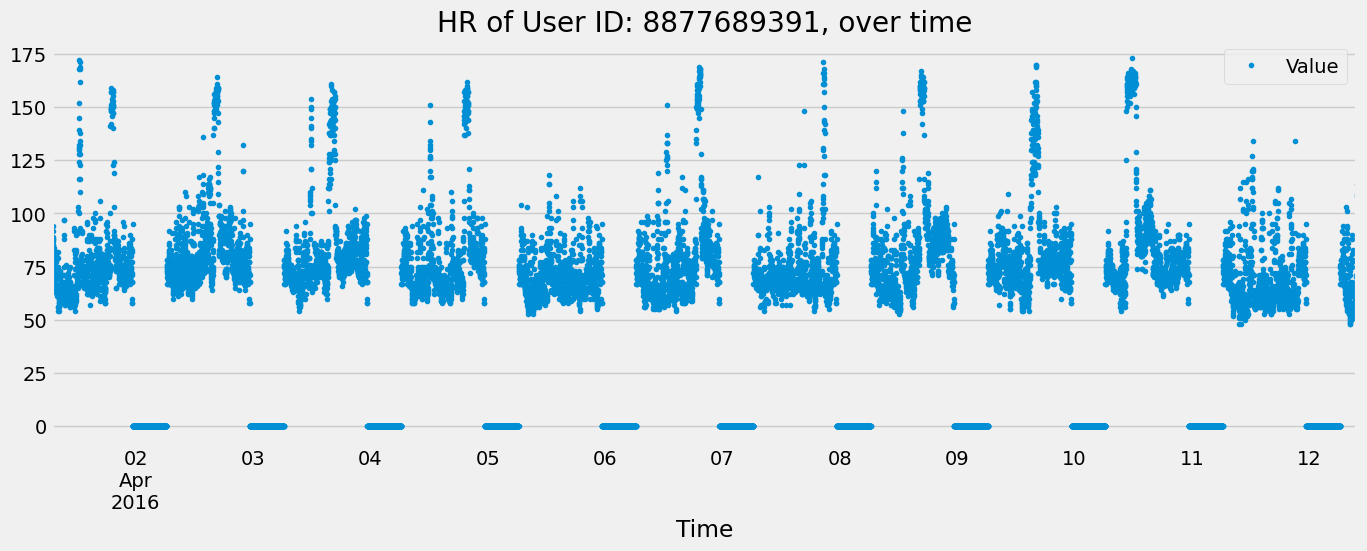

[0]	train-rmse:38.72125	eval-rmse:40.23122


c:\Users\ronys\Documents\RUC\advanced-project\A_P_Python\advanced-project\venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[100]	train-rmse:15.64497	eval-rmse:17.21924
[200]	train-rmse:7.91563	eval-rmse:9.64128
[300]	train-rmse:5.66606	eval-rmse:7.51982
[400]	train-rmse:5.14133	eval-rmse:7.01458
[500]	train-rmse:4.97096	eval-rmse:6.85887
[600]	train-rmse:4.88484	eval-rmse:6.81623
[657]	train-rmse:4.85238	eval-rmse:6.82391


In [44]:
results = []
for user_id in all_ids:
    user_data = df[df['Id'] == user_id][['Time', 'Value']]
    user_data = user_data.set_index('Time')
    user_data.index = pd.to_datetime(user_data.index)
    user_data = user_data.sort_index()
    # Resample to 1-minute intervals, taking the mean value for each minute, round to nearest integer and convert to int type
    # fill NaNs with 0, then round and convert to int
    user_data_min = user_data.resample('1min').mean(numeric_only=True).fillna(0).round().astype('int64')
    print(f"User ID: {user_id}, Number of NaNs before filling: {user_data_min['Value'].isna().sum()}")
    user_data_min = fill_zeros_and_nans_with_minute_avg(user_data_min)
    print(f"User ID: {user_id}, Number of NaNs after filling: {user_data_min['Value'].isna().sum()}")
    hr_plot(user_data_min,user_id)
    rmse, mae = app_model_xgb(user_data_min['Value'])
    results.append({
        'User_ID': user_id,
        'RMSE': rmse,
        'MAE': mae
    })
results_df = pd.DataFrame(results)

In [46]:
# Add 'count' column by mapping User_ID to id_counts
results_df['count'] = results_df['User_ID'].map(id_counts)
results_df

,User_ID,RMSE,MAE,count
0,2022484408,5.275937,2.787253,56483
1,2026352035,53.020697,42.236111,439
2,2347167796,4.460160,2.876449,120804
3,4020332650,3.477129,2.218646,283794
4,4558609924,4.461529,2.835599,69339
5,5553957443,3.219216,1.996221,97797
6,5577150313,5.787418,3.385049,87649
7,6117666160,4.033436,2.690832,53666
8,6391747486,11.103754,6.658803,3747
9,6775888955,3.902432,2.511010,35100


In [48]:
# Sort results_df by 'avg_error' ascending (lowest/best first)
results_df_sorted = results_df.sort_values('avg_error').reset_index(drop=True)

# Display the sorted DataFrame
print(results_df_sorted)

# The best overall is now the first row
print(f"\nBest Overall (Top Row): User {results_df_sorted.iloc[0]['User_ID']} (Avg Error: {results_df_sorted.iloc[0]['avg_error']:.4f})")

       User_ID       RMSE        MAE   count  avg_error
0   5553957443   3.219216   1.996221   97797   2.607718
1   8792009665   3.505733   2.075888   70087   2.790810
2   4020332650   3.477129   2.218646  283794   2.847887
3   6775888955   3.902432   2.511010   35100   3.206721
4   6962181067   4.094360   2.581769  125875   3.338065
5   6117666160   4.033436   2.690832   53666   3.362134
6   4558609924   4.461529   2.835599   69339   3.648564
7   2347167796   4.460160   2.876449  120804   3.668304
8   2022484408   5.275937   2.787253   56483   4.031595
9   7007744171   5.842382   3.150328   64786   4.496355
10  5577150313   5.787418   3.385049   87649   4.586233
11  8877689391   6.826023   3.596471   85115   5.211247
12  6391747486  11.103754   6.658803    3747   8.881278
13  2026352035  53.020697  42.236111     439  47.628404

Best Overall (Top Row): User 5553957443.0 (Avg Error: 2.6077)
